# Pyat Tutorial - Kraken

- Build environment file for Pekeris Wave Guide
- write .flp file for a range and source distribution
- run kraken.exe to solve for modes
- run field.exe to solve for the green's function

In [1]:
import numpy as np
from os import system
from matplotlib import pyplot as plt
from pyat.pyat.env import *
from pyat.pyat.readwrite import *

## Build Environment File

In [2]:
# Environmental parameters
cw = 1500 # water sound speed [m/s]
pw = 1 # density of water [g/cm^3]
aw = 0 # attenuation of water [units determined below]
cb = 1600 # bottom sound speed
pb = 1.8 # density of bottom [g/cm^3]
ab = 0.2 # attenuation of bottom [units determined below]

### Create Position Object
- defines source and reciever locations

In [3]:
sd = 20 # source depth [m]

Z = np.arange(0, 200, .5) # depth of recievers [m]
X = np.arange(0, 10, .01) # range of receivers [km]

s = Source(sd)
r = Dom(X, Z)
pos = Pos(s,r)
pos.s.depth = [sd]
pos.r.depth = Z
pos.r.range = X
pos.Nsd = 1 # number of source depths
pos.Nrd = len(Z) # number of reciever depths

### Sound Speed Object

In [4]:
bottom_depth = 200 # m

# Build SSP to be constant value
z1 = np.linspace(0, bottom_depth, 1000) # depth [m]
alphaR	=	cw*np.ones(z1.shape) # p-wave speed in water
betaR	=	0.0*np.ones(z1.shape) # s-wave speed in water
rho		=	pw*np.ones(z1.shape) # density of water [g/cm^3]
alphaI	=	aw*np.ones(z1.shape) # p-wave attenuation [units are determined by Opt (below)]
betaI	=	0.0*np.ones(z1.shape) # s-wave attenuation [units are determined by Opt (below)]

# create raw sound speed object - package of all arrays above
ssp1 = SSPraw(z1, alphaR, betaR, rho, alphaI, betaI)

### Sound Speed Layer Specifications
- this example uses a single sound speed layer

In [5]:
# Define Sound-speed layer specifications (for this example we are using a single layer)                
depth = [0, bottom_depth] # depth array for layers
NMedia		=	1
Opt			=	'CVW' # C-linear interpolation, Vaccuum top boundary, attenuation in dB/wavelength
# more more detailed information about these options see Kraken User Manual p. 83
N			=	[z1.size] # array with num points in each layer, don't include one for halfpace
sigma		=	[.5,.5]	 # roughness at each layer. only effects attenuation (imag part)

# create sound speed object
ssp = SSP([ssp1], depth, NMedia, Opt, N, sigma)

### Define Boundary Conditions

In [6]:
# create halph space object for the bottom
hs = HS(alphaR=cb, betaR=0, rho = pb, alphaI=ab, betaI=0)
Opt = 'A' # acousto-elastic half space, 

# create Bottom Boundary Object
bottom = BotBndry(Opt, hs)

# create Top Boundary Object
top = TopBndry('CVW')

# create boundary object for both top and bottom
bdy = Bndry(top, bottom)

### Write Environment File

In [7]:
class Empty:
    def __init__(self):
        return

cInt = Empty()
cInt.High = 999999999
cInt.Low = 0 # compute automatically
RMax = 100
freq = 400
write_env('py_env.env', 'KRAKEN', 'Pekeris profile', freq, ssp, bdy, pos, [], cInt, RMax)

## Build .flp file
- most of the work has already done to create the flp file, the file just needs to be written

In [8]:
write_fieldflp('py_env', 'R', pos)

## Run Kraken.exe and Field.exe
Results in:
- .mod file containing the solved modes
- .shd file containing the green's function for given reciever and source locations

In [9]:
# These can be run in the terminal as well

os.system('kraken.exe py_env')
os.system('field.exe py_env')

0

## Read the .mod and .shd files

In [10]:
fname = 'py_env.mod'
options = {'fname':fname, 'freq':0}
modes = read_modes(**options)
print(modes)

Modes object with 107 distinct modes


/Users/jhrag/opt/anaconda3/envs/ooi_dev9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'First 10 Mode Shapes')

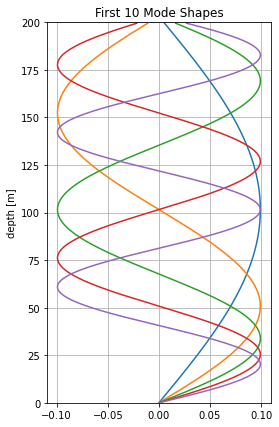

In [11]:
plt.figure(figsize=(4,7))
plt.plot(modes.phi[:,0:5], modes.z)
plt.gca().invert_yaxis()
plt.ylabel('depth [m]')
plt.grid()
plt.ylim([0,200])
plt.title('First 10 Mode Shapes')

In [12]:
[x,x,x,x,Pos1,pressure]= read_shd('py_env.shd')

ext .shd


Text(0.5, 1.0, 'Greens function')

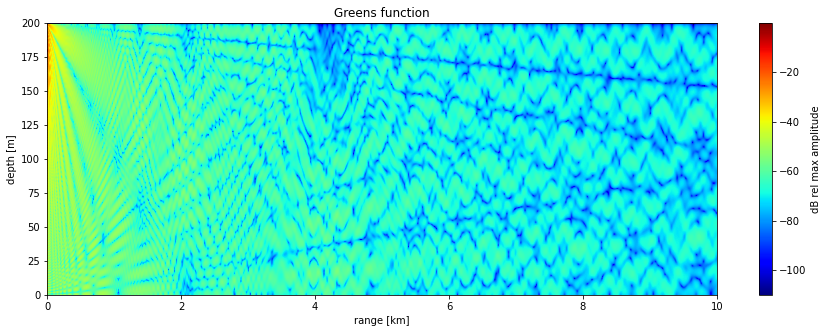

In [13]:
plt.figure(figsize=(15,5))
plt.imshow(20*np.log10(np.abs(pressure[0,0,:,:])/np.max(np.abs(pressure))), cmap='jet', aspect='auto', extent=[0,10,0,200])
cbar = plt.colorbar()
plt.clim([0,-100])
cbar.ax.set_ylabel('dB rel max amplitude')
plt.xlabel('range [km]')
plt.ylabel('depth [m]')
plt.title('Greens function')

Text(0.5, 1.0, 'Greens Function (zoomed)')

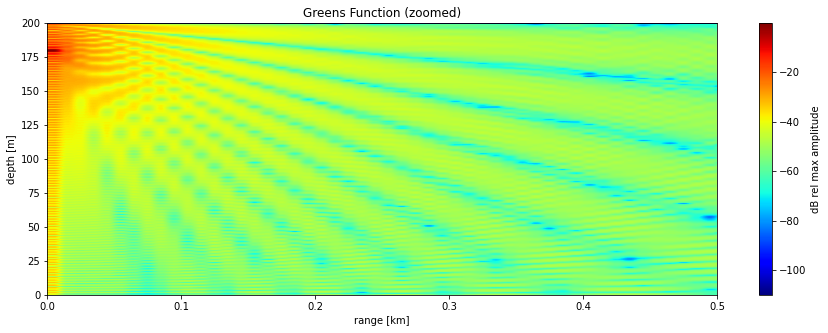

In [14]:
plt.figure(figsize=(15,5))
plt.imshow(20*np.log10(np.abs(pressure[0,0,:,:])/np.max(np.abs(pressure))), cmap='jet', aspect='auto', extent=[0,10,0,200])
cbar = plt.colorbar()
plt.clim([0,-100])
cbar.ax.set_ylabel('dB rel max amplitude')
plt.xlabel('range [km]')
plt.ylabel('depth [m]')
plt.xlim([0,0.5])
plt.title('Greens Function (zoomed)')